### This Notebook plots good settings

In [1]:
# Bonus cell for using the different test set

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from copy import copy
from matplotlib import cm, colors
import cv2

# Två delar:
# 1: fixa segmentstorleken
# 2: fixa masker för varje segment
# Eller egentligen, skit i det. Applicera masken i förväg?


def getTestObjects(porositythreshold=0.5): 
    objectwidth = 100
    objectheight = 100
    xspacing = 116
    yspacing = 300
    xstart = 293
    ystart = 445
    xend = 1730
    yend = 1770
    powderthickness = 80
    endlayer = 225
    vsegments = [0, 150, 187, endlayer]

    paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
    paths_sorted = [x for x in paths]
    paths_sorted.sort()
    integrals = np.array([np.array(plt.imread(path)) for path in paths_sorted])

    objectinfo = pd.read_csv('Parameters2.csv', names=["Object", "P", "S", "H", "Porosity", "Label"])
    objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
        ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
    coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])
    objectinfo = coorddf.join(objectinfo)

    objectinfo.replace('GOOD', 0, inplace=True)
    objectinfo.replace('LOF', 1, inplace=True)
    objectinfo.reset_index(drop=True, inplace=True)

    objects = np.full((len(objectinfo), endlayer, objectheight, objectwidth), np.nan)

    for index, object in objectinfo.iterrows():
        objects[index] = integrals[:, object.ystart:object.yend, object.xstart:object.xend]

    rtn = np.full(objects.shape, np.nan)
    aggregate = np.sum(objects, axis=(0))

    emptyRatio = 30
    limit = np.percentile(aggregate, emptyRatio)
    testmask = aggregate >= limit
    for object in objects:
        object[~testmask] = np.nan

    # Create the good frame
    segmentdf = pd.read_csv('Segments2.csv', names=["Object", "Objectnumber", "Segment", "P", "S", "H", "Porosity"])
    segmentdf.insert(1, "VED", segmentdf.P * 1000/(segmentdf.S * segmentdf.H * powderthickness))
    segmentdf.insert(1, "Label", np.where(segmentdf.Porosity > porositythreshold, 1, 0))
    # segmentdf.drop(segmentdf[(segmentdf.VED > 50)].index, inplace=True)
    segmentdf.reset_index(drop=True, inplace=True)
    vs = [[vsegments[j], vsegments[j+1]] for i in range(0, len(objects)) for j in reversed(range(0, len(vsegments)-1))]
    coorddf = pd.DataFrame(vs, columns=['zstart', 'zend'])
    testobjectinfo = coorddf.join(segmentdf)
    testobjectinfo.drop(testobjectinfo[(testobjectinfo.Objectnumber == 28) | (testobjectinfo.Objectnumber == 21) ].index, inplace=True)
    testobjectinfo.reset_index(drop=True, inplace=True)

    testobjects = [objects[object.Objectnumber-1, object.zstart:object.zend] for index, object in testobjectinfo.iterrows()]

    del objects
    del objectinfo
    del coorddf
    del objectCoordinates
    del paths_sorted
    del integrals
    print("fetching data with ", porositythreshold)
    return testobjects, testobjectinfo

In [2]:
# Read train data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from copy import copy
from matplotlib import cm, colors
import cv2

def getTrainObjects(objectsplit=1, upsamplingratio=1, positive_multiplier=1, porositythreshold=0.5, separate_test=True):
    emptyRatio = 47
    objectwidth = 83
    objectheight = 122
    xspacing = 133
    yspacing = 270
    xstart = 293
    ystart = 268
    xend = 1730
    yend = 1770
    hsegments = [0,26,50,74,98,122]
    powderthickness = 80
    endlayer = 187

    paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
    paths_sorted = [x for x in paths]
    paths_sorted.sort()
    block = np.array([np.array(plt.imread(path)) for path in paths_sorted])
    integrals = block[0:endlayer]

    del paths_sorted
    objectinfo = pd.read_csv('Parameters.csv', names=["Object", "P", "S", "H", "Porosity", "Label"])

    objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
        ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
    coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])
    objectinfo = coorddf.join(objectinfo)

    objects = np.full((len(objectinfo), endlayer, objectheight, objectwidth), np.nan)

    for index, object in objectinfo.iterrows():
        objects[index] = integrals[:, object.ystart:object.yend, object.xstart:object.xend]

    aggregate = np.sum(objects, axis=(0,1))

    emptyRatio = 47
    limit = np.percentile(aggregate, emptyRatio)
    mask = aggregate >= limit
    mask = np.repeat([mask], endlayer, 0)

    for object in objects:
        object[~mask] = np.nan

    # Time to construct the "real" dataframe

    segmentdf = pd.read_csv('Segments.csv', names=["Object", "Objectnumber", "Segment", "P", "S", "H", "Porosity", "Area"])
    segmentdf.insert(1, "VED", segmentdf.P * 1000/(segmentdf.S * segmentdf.H * powderthickness))
    segmentdf.insert(1, "Label", np.where(segmentdf.Porosity > porositythreshold, 1, 0))
    originalframe = segmentdf.copy()
    hs = [[hsegments[j], hsegments[j+1]] for i in range(0, len(objects)) for j in range(0, len(hsegments)-1)]
    coorddf = pd.DataFrame(hs, columns=['hstart', 'hend'])
    segmentdf = coorddf.join(segmentdf)

    # Start of object multiplication 
    layersPerObject = endlayer // objectsplit
    testEnd = endlayer if separate_test else endlayer - layersPerObject * (objectsplit // 3)
    zs = [segmentdf.copy().assign(zstart=z, zend=z+layersPerObject) for z in range(0, testEnd-layersPerObject+1, layersPerObject//(upsamplingratio * positive_multiplier))]
    testzs = [segmentdf.copy().assign(zstart=testEnd, zend=endlayer)]
    trainobjectinfo = pd.concat(zs, ignore_index=True)
    trainobjectinfo.drop(trainobjectinfo[(trainobjectinfo.Objectnumber == 28) | (trainobjectinfo.Objectnumber == 21) ].index, inplace=True)
    trainobjectinfo.reset_index(drop=True, inplace=True)
    testobjectinfo = pd.concat(testzs, ignore_index=True)

    # Removes extra rows 
    trainobjectinfo = trainobjectinfo[(trainobjectinfo['Label'] == 1) | (trainobjectinfo['zstart'] % (positive_multiplier) == 0)]

    trainobjects = [objects[object.Objectnumber-1, object.zstart:object.zend, object.hstart:object.hend] for index, object in trainobjectinfo.iterrows()]
    testobjects = [objects[object.Objectnumber-1, object.zstart:object.zend, object.hstart:object.hend] for index, object in testobjectinfo.iterrows()]

    print("fetching data with objectsplit: {}, upsamplingratio: {}, positive_multiplier: {}, porositythreshold: {}".format(objectsplit, upsamplingratio, positive_multiplier, porositythreshold))
    return trainobjects, trainobjectinfo

# assert(np.average(np.isfinite(trainobjects)) == 1)
# assert(np.average(np.isfinite(testobjects)) == 1)
# xs = np.copy(aggregate)
# xs[~backgroundmask] = np.nan
# plt.imshow(xs)
# plt.figure()

In [3]:
from sklearn import neighbors, metrics
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from datetime import datetime
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import tree
import warnings

def preprocess(objects, type, sharpening):
    rtn = []
    # print(rtn.shape)
    for index, object in enumerate(objects):
        sharpened = object
        if(sharpening != 'none'):
            sharpeningKernel = np.array([   [-1, -1,  -1],
                                        [-1,  9,  -1],
                                        [ -1, -1,  -1]
        ]) if sharpening == 'diagonal' else np.array([  [0, -1,  0],
                                                        [-1, 5, -1],
                                                        [0, -1,  0]])
            sharpened = np.array([cv2.filter2D(src=image, ddepth=-1, kernel=sharpeningKernel) for image in object])
        # Sharpening is done
        if type == 'scatter' or type == 'spatstat':
            xs = np.array(sharpened, copy=True, dtype=np.float32)
            rtn.append(xs)
        elif type == 'moran':
            xs = np.array(sharpened, copy=True, dtype=np.float32)
            avg = np.nanmean(xs)
            stddev = np.nanstd(xs)
            xs = (xs - avg) / avg
            rtn.append(xs)
    return rtn


def calculateoutliers(objects, type, neighbourhoodSetting, windowSize):
    # c, z, y, x = objects.shape

    outlierValues = []
    index = 0
    # return objects
    for object in objects:
        z, y, x = object.shape
        # Step 1: calculate neighbourhood
        neighbourkernel = np.ones((neighbourhoodSetting, neighbourhoodSetting)) / neighbourhoodSetting**2
        flatNeighbourhood = np.array([cv2.filter2D(src=layer, ddepth=-1, kernel=neighbourkernel) for layer in object])
        neighbourhoodValues = np.array([
            np.sum(flatNeighbourhood[layerIndex-windowSize:layerIndex], axis=0)/windowSize
            for layerIndex in range(windowSize, z+1)
        ])
        # Step 2: calculate outlier
        offset = windowSize // 2
        endoffset = windowSize - offset - 1

        ys = neighbourhoodValues[0:z-windowSize+1]
        xs = object[offset:z-endoffset]
        filter = np.logical_and(np.isfinite(xs), np.isfinite(ys))

        # plt.imshow(xs[0])
        # plt.figure()
        # plt.imshow(xs[0])
        # plt.figure()
        # if(index == 58):
        #     plt.imshow(xs[0])
        #     plt.figure()
        #     plt.imshow(ys[0])
        #     plt.figure()
        #     plt.imshow(filter[0])
        #     plt.figure()
        #     print(len(np.unique(filter)))
        numberOfFilterValues = len(np.unique(filter))
        # print("filterlength is: ", numberOfFilterValues)
        # print("index is:", index)
        assert numberOfFilterValues == 2, f"Expected filter to have two values, got: {numberOfFilterValues}"
        if type == 'spatstat':
            outliers = xs - ys
            avg = np.mean(outliers[filter])
            std = np.std(outliers[filter])
            outliers = (outliers - avg) / std
            outlierValues.append(outliers)
        else:
            with warnings.catch_warnings():
                line = np.polyfit(xs[filter].flatten(), ys[filter].flatten(), 1)
                p = np.poly1d(line)
                outlierValues.append(p(xs) - ys)
            # plt.scatter(xs[filter].flatten(), ys[filter].flatten())
            # plt.axline((-0.1, p(-0.1)), (0, p(0)), linewidth=2, color='b')
            # plt.figure()
            assert(xs.shape == p(ys).shape)
        assert(len(np.unique(outlierValues[index])) > 1)
        assert(len(np.unique(np.isfinite(outlierValues[index]))) == 2)
        index+=1
    # print("okidk ", np.average(np.isfinite(outlierValues)))
    # assert(np.average(np.isfinite(outlierValues)) > 0.4)
    return outlierValues

def encode(outlierobjects, type, buckets, minval=0, maxval=0, transformer=None):
    numberOfObjects = len(outlierobjects)
    X = np.full((numberOfObjects, buckets), np.nan)
    raw = np.concatenate([oo.flatten() for oo in outlierobjects])
    filter = np.isfinite(raw)
    minval = np.min(raw[filter]) if minval == 0 else minval
    maxval = np.max(raw[filter]) if maxval == 0 else maxval
    for index in range(0, numberOfObjects):
        xs = outlierobjects[index]
        filter = np.isfinite(xs)
        hist, edges = np.histogram(xs[filter], bins=buckets, range=(minval, maxval), density=True)
        X[index] = np.array(hist)
    
    return X, minval, maxval, edges, transformer

def classify(Xtrain, Ytrain, Xtest, Ytest, histnormalise=True):
    clf = neighbors.KNeighborsClassifier() if type == 'knn' else RandomForestClassifier()
    if (histnormalise == True):
        clf = Pipeline([('scaler', StandardScaler()), ('classifier', clf)])
    cvs = cross_val_score(clf, Xtrain, Ytrain, cv=10, scoring='roc_auc', n_jobs=-1)
    clf.fit(Xtrain, Ytrain)
    metrics.plot_roc_curve(clf, Xtest, Ytest)
    Yfit = clf.predict(Xtest)
    return Yfit
    # How do we return values for the POD? 
    # We want to return the ratio...

In [4]:
# parameter settings
types = ['scatter', 'spatstat', 'moran', ]
sharpening = ['none', 'direct',]
windowsizes = [1, 3, 5, 7]
neighbourhoodsize = [3, 5, 7]
bins = [5, 10, 20, 40, 80]
histnormalise = [True, False]
k = [3,5,10,15]

In [5]:
# Narrow settings for iterating
types = ['scatter', 'spatstat', 'moran']
sharpening = ['none']
windowsizes = [1, 3, 5]
neighbourhoodSetting = ['grid']
bins = [5,10,20,40]
histnormalise = [True, False]
k = [5,10,15]

In [6]:
# parameter settings for the report. Might wanna expand down the line?
types = ['scatter', 'spatstat', 'moran']
sharpening = ['none']
windowsizes = [1, 3, 5, 7]
neighbourhoodsize = [3, 5, 7]
bins = [5, 10, 20, 40, 80]
histnormalise = [True]
k = [5]

In [15]:
from sklearn import metrics

# Now to tie it all together...
settingcolumns = ['threshold', 'classifier', 'type', 'z', 'xy', 'bins']
settings =  pd.DataFrame([
    [0.1, 'KNN', 'moran', 1, 3, 20],
    [0.1, 'KNN', 'moran', 1, 3, 80],
], columns=settingcolumns)

def getPodAndPlotRoc (trainobjects, trainobjectinfo, testobjects, testobjectinfo, threshold, classifier, type, z, xy, bins):
    sharpSetting = 'none'

    Ytrain = np.array(trainobjectinfo.loc[:,"Label"])
    Ytest = np.array(testobjectinfo.loc[:,"Label"])
    trainpreprocessed =preprocess(trainobjects, type, sharpSetting)
    testpreprocessed =preprocess(testobjects, type, sharpSetting)

    trainoutliers = calculateoutliers(trainpreprocessed, type, xy, z)
    testoutliers = calculateoutliers(testpreprocessed, type, xy, z)

    Xtrain, minval, maxval, edges, transformer = encode(trainoutliers, type, bins)
    Xtest, _, _, _, _ = encode(testoutliers, type, bins, minval=minval, maxval=maxval, transformer=transformer)

    # Print in the classify function, can't do it outside? 
    Ypred = classify(Xtrain, Ytrain, Xtest, Ytest)
    
    limits = np.logspace(-1, 1, num=20)
    limits = np.array([0.0,0.1,0.2,0.3,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2])

    recall = [metrics.recall_score(np.where(testobjectinfo.Porosity > limit, 1, 0), Ypred) for limit in limits ]
    precision = [metrics.precision_score(np.where(testobjectinfo.Porosity > limit, 1, 0), Ypred) for limit in limits ]
    return (limits, recall, precision)

In [8]:
# Now to tie it all together...
settingcolumns = ['threshold', 'classifier', 'type', 'z', 'xy', 'bins']
settings =  pd.DataFrame([
    [0.1, 'KNN', 'moran', 1, 3, 5],
    # ...
], columns=settingcolumns)

fetching data with  0.1
fetching data with objectsplit: 1, upsamplingratio: 1, positive_multiplier: 1, porositythreshold: 0.1


/Users/erik/Git/thesis/thesis-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/erik/Git/thesis/thesis-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


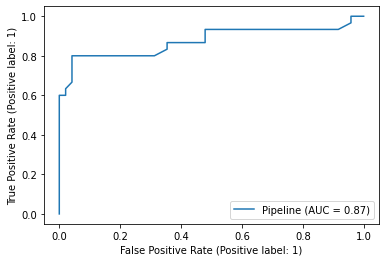

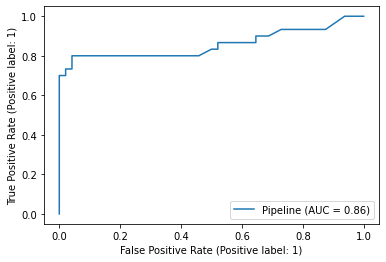

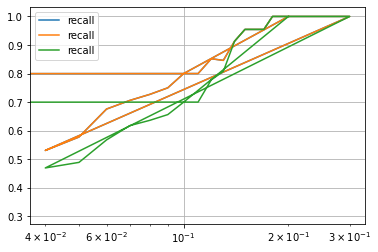

In [22]:
from distutils.file_util import write_file
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors, metrics
from sklearn import tree
from sklearn.inspection import DecisionBoundaryDisplay

# Read data

# Do the things
# Check the baseline
# for i in [0.1, 0.25, 0.5]:
oldThreshold = 0
scores = []
for index, object in settings.iterrows():
    if(object.threshold != oldThreshold):
        testobjects, testobjectinfo = getTestObjects(porositythreshold=object.threshold)
        trainobjects, trainobjectinfo = getTrainObjects(porositythreshold=object.threshold)
        oldThreshold = object.threshold
    scores.append(getPodAndPlotRoc(trainobjects, trainobjectinfo, testobjects, testobjectinfo, object.threshold, object.classifier, object.type, object.z, object.xy, object.bins))
plt.figure()
# Add the baseline
Ytrain = np.array(trainobjectinfo.loc[:,"Label"])
Ytest = np.array(testobjectinfo.loc[:,"Label"])
Xtrain = np.array([np.nanmean(object) for object in trainobjects])
Xtest = np.array([np.nanmean(object) for object in testobjects])
clf = tree.DecisionTreeClassifier(max_depth=1)
clf.fit(Xtrain.reshape(-1, 1), Ytrain)
Ypred = clf.predict(Xtest.reshape(-1, 1))
limits = np.array([0.0,0.1,0.2,0.3,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2])
recall = [metrics.recall_score(np.where(testobjectinfo.Porosity > limit, 1, 0), Ypred) for limit in limits ]
precision = [metrics.recall_score(np.where(testobjectinfo.Porosity > limit, 1, 0), Ypred) for limit in limits ]
scores.append((limits, recall, precision))

for (x, y1, y2) in scores:
    plt.plot(x, y1, label='recall')
    # plt.plot(x, y2, label='precision')
plt.grid(visible=True)
plt.legend()
plt.xscale('log')

[0.   0.1  0.2  0.3  0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2 ]
[(0.34615384615384615,), (0.8,), (1.0,), (1.0,), (0.5306122448979592,), (0.5777777777777777,), (0.6756756756756757,), (0.7058823529411765,), (0.7272727272727273,), (0.75,), (0.8,), (0.8,), (0.8518518518518519,), (0.8461538461538461,), (0.9130434782608695,), (0.9545454545454546,), (0.9545454545454546,), (0.9545454545454546,), (1.0,), (1.0,), (1.0,)]
[0.   0.1  0.2  0.3  0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2 ]
[(0.34615384615384615,), (0.8,), (1.0,), (1.0,), (0.5306122448979592,), (0.5777777777777777,), (0.6756756756756757,), (0.7058823529411765,), (0.7272727272727273,), (0.75,), (0.8,), (0.8,), (0.8518518518518519,), (0.8461538461538461,), (0.9130434782608695,), (0.9545454545454546,), (0.9545454545454546,), (0.9545454545454546,), (1.0,), (1.0,), (1.0,)]
[0.   0.1  0.2  0.3  0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 

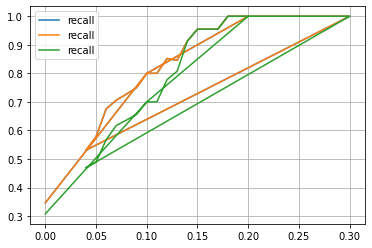

In [24]:
plt.figure()
for (x, y1, y2) in scores:
    plt.plot(x, y1, label='recall')
    print(x)
    print(y1)
    # plt.plot(x, y2, label='precision')
    plt.grid(visible=True)
    plt.legend()

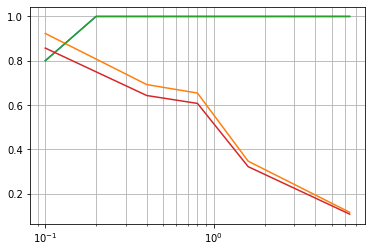

In [34]:
for (x, y1, y2) in scores:
    plt.plot(x, y1, label='recall')
    plt.plot(x, y2, label='precision')
    plt.grid(visible=True, which='both')
    plt.xscale('log')